# CytOpt on a 2 classes framework

In this notebook we apply our method CytOpt in a simple case where our data are separated in two classes. This example is designed to help the reader to understand our method.

The source data set is Stanford1A and the target data set is Stanford3A

##### Import modules and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

import CytOpT.CytOpt as cytopt
import CytOpT.labelPropSto as lps

#### Data import

In [2]:
Stanford1A_values = pd.read_csv('../../data/W2_1_values.csv',
                                usecols = np.arange(1,8))
Stanford1A_clust = pd.read_csv('../../data/W2_1_clust.csv',
                               usecols = [1])
Stanford3A_values = pd.read_csv('../../data/W2_7_values.csv', 
                           usecols = np.arange(1,8))
Stanford3A_clust = pd.read_csv('../../data/W2_7_clust.csv',
                          usecols = [1])

##### 2D projection using two markers. 
The data are divided into two classes: the CD4 cells where the CD4 marker is present and the CD8 cells where the CD8 marker is present.

In [3]:
X_source = np.asarray(Stanford1A_values[['CD4', 'CD8']])
X_target = np.asarray(Stanford3A_values[['CD4', 'CD8']])

X_sou_display = np.asarray(Stanford1A_values[['CD4', 'CD8']])
X_tar_display = np.asarray(Stanford3A_values[['CD4', 'CD8']])

Lab_source = np.asarray(Stanford1A_clust['x'] >= 6, dtype=int)
Lab_target = np.asarray(Stanford3A_clust['x'] >= 6, dtype=int)
names_pop = ['CD8', 'CD4']

##### Computation of the benchmark class proportions

In [4]:
h_source = np.zeros(2)
for k in range(2):
    h_source[k] = np.sum(Lab_source == k)/len(Lab_source)

h_true = np.zeros(2)
for k in range(2):
    h_true[k] = np.sum(Lab_target == k)/len(Lab_target)

### Illustration of the framework
A segmented data set and an unlabelled target data set.

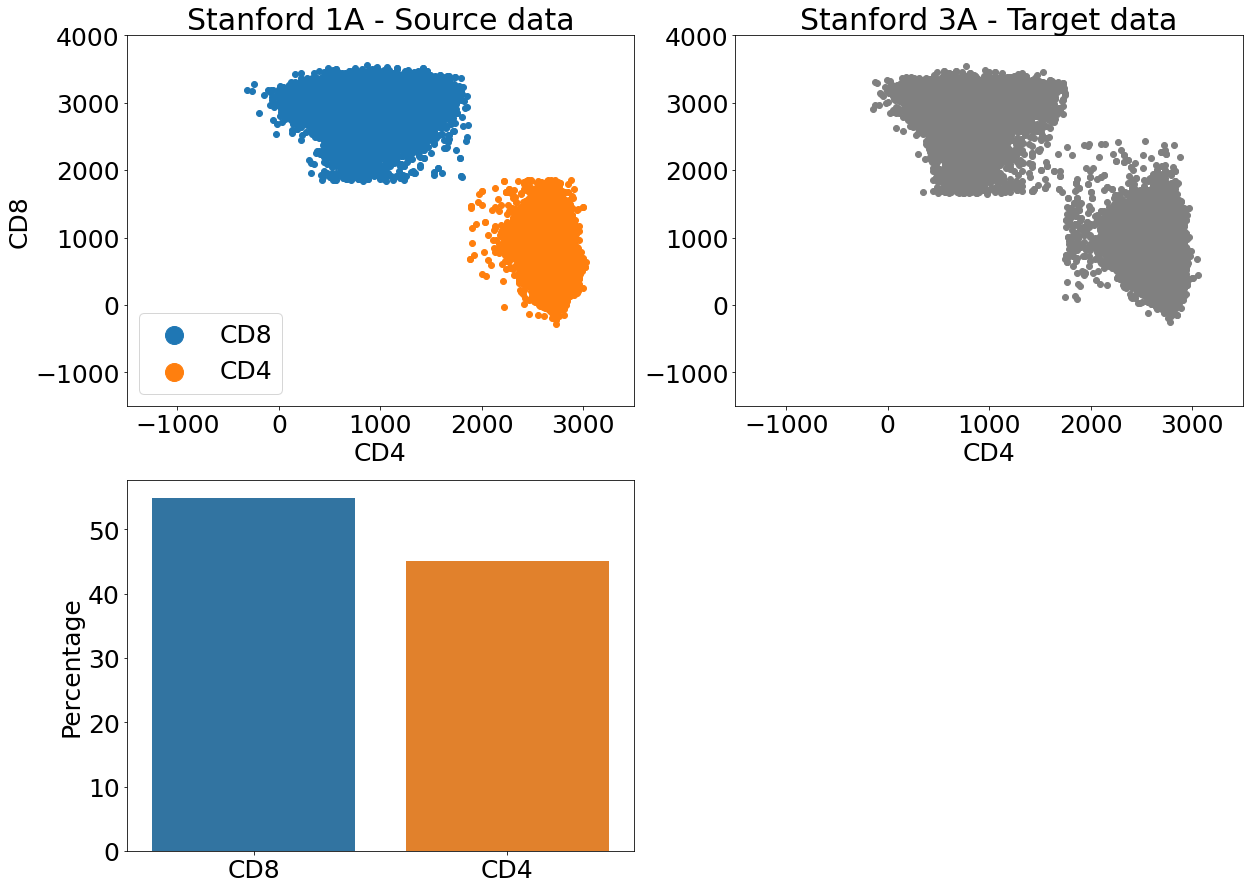

In [5]:
plt.figure(figsize=(20,15))
plt.subplot(2,2,1)
for it in [0,1]:
    plt.scatter(X_source[Lab_source==it,0], X_source[Lab_source==it,1],
               label=names_pop[it])
plt.xlabel('CD4', size=25)
plt.ylabel('CD8', size=25)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower left', fontsize=25, markerscale=3)
plt.title('Stanford 1A - Source data', size=30)


plt.subplot(2,2,2)
plt.scatter(X_target[:,0], X_target[:,1], c='grey')
plt.xlabel('CD4', size=25)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.title('Stanford 3A - Target data', size=30)

plt.subplot(2,2,3)
sns.barplot(x=names_pop, y=100*h_source)
plt.ylabel('Percentage', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25);


In [6]:
I = X_source.shape[0]
J = X_target.shape[0]

alpha = 1/I * np.ones(I)
beta = 1/J * np.ones(J)

# Preprocessing of the data

X_source = X_source * (X_source > 0)
X_target = X_target * (X_target > 0)

scaler = MinMaxScaler()
X_source = scaler.fit_transform(X_source)
X_target = scaler.fit_transform(X_target)

## Classification using optimal transport

##### without reweighting

##### Approximation of the optimal dual vector u.

In order to compute an approximation of the optimal transportation plan, we need to approximate $P_{\varepsilon}$.

In [7]:
eps = 0.02
n_iter = 1000

t0 = time.time()
Res_RM = lps.robbinsWass(X_source, X_target, alpha, beta, eps=eps, nIter=n_iter)
elapsed_time = time.time() - t0

u_last = Res_RM[0]
W_hat = Res_RM[1]
Sig_hat = Res_RM[2]

In [8]:
print('Elapsed time :', elapsed_time/60, 'mins')

Elapsed time : 0.014298049608866374 mins


##### Label propagation

In [9]:
L_source = np.zeros((2,I))
for k in range(2):
    L_source[k] = np.asarray(Lab_source == k, dtype = int)
    
t0 = time.time()
Result_LP = lps.labelPropSto(L_source, u_last, X_source, X_target, alpha, beta, eps)
elapsed_time = time.time()-t0
Lab_target_hat_one = Result_LP[1]

[3.19060685e-05 3.19060685e-05 3.19060685e-05 ... 3.19060685e-05
 3.19060685e-05 3.19060685e-05]
Running Computation of cTransform...
Computation of cTransform done.


In [10]:
print('Elapsed_time ', elapsed_time/60, 'mins')

Elapsed_time  0.42239905993143717 mins


In [11]:
X_tar_display = np.asarray(Stanford3A_values[['CD4', 'CD8']])

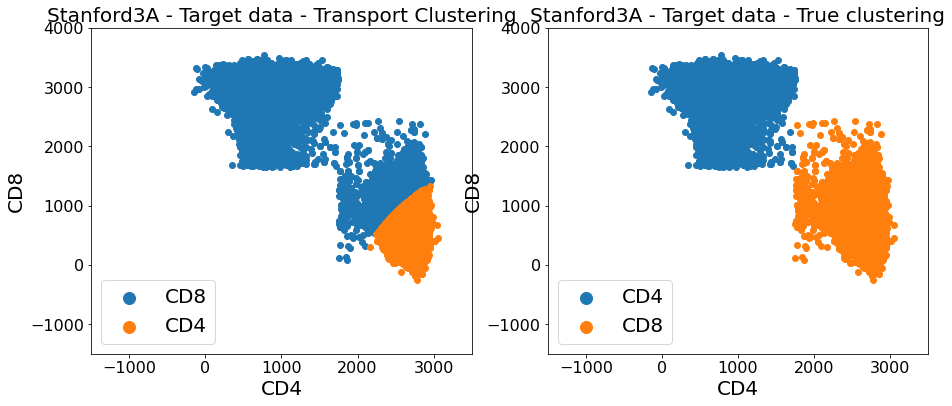

In [12]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
for it in [1,2]:
    plt.scatter(X_tar_display[Lab_target_hat_one==it,0],
                X_tar_display[Lab_target_hat_one==it,1],
               label=names_pop[it-1])
plt.xlabel('CD4', size=20)
plt.ylabel('CD8', size=20)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower left', fontsize=20, markerscale=2)
plt.title('Stanford3A - Target data - Transport Clustering', size=20)


plt.subplot(1,2,2)
for it in [0,1]:
    plt.scatter(X_tar_display[Lab_target==it,0],
                X_tar_display[Lab_target==it,1],
               label=names_pop[it-1])
plt.xlabel('CD4', size=20)
plt.ylabel('CD8', size=20)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc='lower left', fontsize=20, markerscale=2)
plt.title('Stanford3A - Target data - True clustering', size=20);

## Class proportions estimation with ${\tt CytOpt}$


### Descent-Ascent procedure

##### Setting of the parameters

In [13]:
n_it_grad = 1000
n_it_sto = 10
pas_grad = 1
eps=0.0005

In [14]:
t0 = time.time()
t0 = time.time()
h_hat = cytopt.CytOpT(xSource=X_source, xTarget=X_target, labSource=Lab_source, 
                      method="desasc",minMaxScaler=False,thresholding=False,
                      nItGrad=n_it_grad,nItSto=n_it_sto, stepGrad=pas_grad, eps=eps,monitoring=False)

elapsed_time = time.time()-t0
h_hat

Running Desent-ascent optimization...
Iteration  0
Current h_hat
[0.50115553 0.49884447]
Done ( 29.113 s)
Done ( 29.116963624954224 s)



{'proportions':    GoldStandard    desasc
 0      0.450769  0.409185
 1      0.000000  0.590815}

In [15]:
h_hat = np.array(h_hat['proportions']['desasc'])

In [16]:
print('Elapsed time:', elapsed_time/60, 'mins')

Elapsed time: 0.48723511695861815 mins


##### ${\tt CytOpt}$ estimation and benchmark estimation

In [17]:
print('Estimated proportions', h_hat)
print('Benchmark proportions', h_true)

Estimated proportions [0.40918542 0.59081458]
Benchmark proportions [0.26079666 0.73920334]


### Minmax swapping procedure

##### Setting of the parameters

In [18]:
lbd = 0.0001
eps_two = 0.0001
n_iter = 1000
step_size = 5
power = 0.99

### Classification using optimal transport with reweighted proportions

#### The target measure $\beta$ is reweighted in order to match the weight vector $\hat{h}$ estimated with ${\tt CytOpt}$.

In [19]:
D = np.zeros((I,2))
D[:,0] = 1/np.sum(Lab_source == 0) * np.asarray(Lab_source == 0, dtype=float)
D[:,1] = 1/np.sum(Lab_source == 1) * np.asarray(Lab_source == 1, dtype=float)
alpha_mod = D.dot(np.asarray(h_hat))

##### Approximation of the optimal dual vector u.

In [20]:
eps = 0.02
n_iter = 1000

t0 = time.time()
Res_RM2 = lps.robbinsWass(X_source, X_target, alpha_mod, beta, eps=eps, nIter=n_iter)
elapsed_time = time.time() - t0

u_last_two = Res_RM2[0]
W_hat = Res_RM2[1]
Sig_hat = Res_RM2[2]

In [21]:
print('Elapsed time :', elapsed_time/60, 'mins')

Elapsed time : 0.0157377560933431 mins


#### Label propogation

In [22]:
t0 = time.time()
Result_LP = lps.labelPropSto(L_source, u_last_two, X_source, X_target, alpha_mod, beta, eps)
elapsed_time = time.time()-t0
Lab_target_hat_two = Result_LP[1]

[2.37705022e-05 2.37705022e-05 2.37705022e-05 ... 4.18186987e-05
 4.18186987e-05 4.18186987e-05]
Running Computation of cTransform...
Computation of cTransform done.


### Display of the label transfer results without or with reweighting.

Text(0.5, 1.0, 'Manual gating')

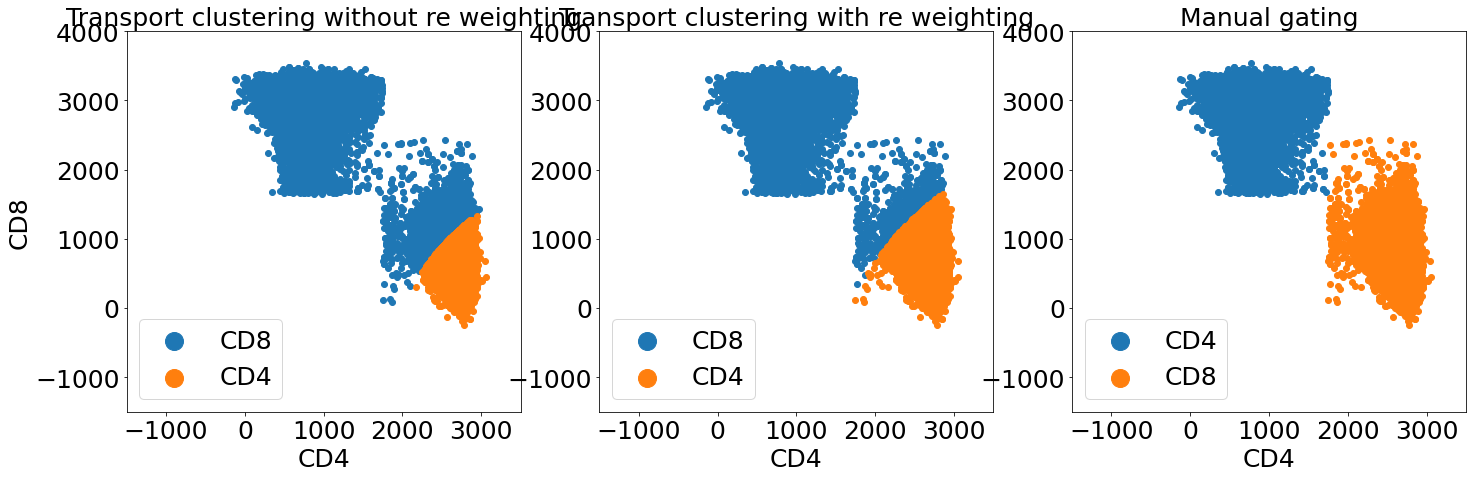

In [23]:
plt.figure(figsize=(24,7))
#plt.suptitle('Target Data : CIMR3A', size=25)

plt.subplot(1,3,1)
for it in [1,2]:
    plt.scatter(X_tar_display[Lab_target_hat_one==it,0],
                X_tar_display[Lab_target_hat_one==it,1],
               label=names_pop[it-1])
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.ylabel('CD8', size=25)
plt.xlabel('CD4', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower left', fontsize=25, markerscale=3)
plt.title('Transport clustering without re weighting', size=25)


plt.subplot(1,3,2)
for it in [1,2]:
    plt.scatter(X_tar_display[Lab_target_hat_two==it,0],
                X_tar_display[Lab_target_hat_two==it,1],
               label=names_pop[it-1])
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xlabel('CD4', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower left', fontsize=25, markerscale=3)
plt.title('Transport clustering with re weighting', size=25)


plt.subplot(1,3,3)
for it in [0,1]:
    plt.scatter(X_tar_display[Lab_target==it,0],
                X_tar_display[Lab_target==it,1],
               label=names_pop[it-1])
#plt.text(-5000, -2200, 'CD4', ha='center', size = 25)
#plt.text(-14500, 1400, 'CD8', va='center', rotation='vertical', size = 25)
plt.xlim(-1500,3500)
plt.ylim(-1500,4000)
plt.xlabel('CD4', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='lower left', fontsize=25, markerscale=3)
plt.title('Manual gating', size=25)
#plt.savefig(fname ='Transfert_CD48_Article.jpeg', format='jpeg', dpi=350);